提前提取好的特征：bert, sentiment, 还有一些计数

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/xtzx/hw6/data/clean.csv', sep='\t')
train_df

,Unnamed: 0,reviewerID,asin,reviewText,overall,votes_up,votes_all,label,text_clean,sentiment,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
0,0,7885,3901,"First off, allow me to correct a common mistak...",5.0,6,7,0,first allow correct common mistake made one re...,0.198494,416,1987,13,4.776442,32.000000
1,1,52087,47978,I am really troubled by this Story and Enterta...,3.0,99,134,0,really troubled story entertained way presente...,0.030000,477,2225,21,4.664570,22.714286
2,2,5701,3667,A near-perfect film version of a downright glo...,4.0,14,14,1,nearperfect film version downright gloomy play...,0.221667,71,357,4,5.028169,17.750000
3,3,47191,40892,Keep your expectations low. Really really low...,1.0,4,7,0,keep expectation low really really low may ent...,-0.106471,117,577,14,4.931624,8.357143
4,4,40957,15367,"""they dont make em like this no more...""well.....",5.0,3,6,0,dont make em like morewell throw phrase window...,0.037500,98,461,21,4.704082,4.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57034,57034,58315,29374,"If you like beautifully shot, well acted films...",2.0,12,21,0,like beautifully shot well acted film plot lin...,0.206563,478,2037,25,4.261506,19.120000
57035,57035,23328,45548,This is a great set of films Wayne did Fox and...,5.0,15,18,0,great set film wayne fox mgm contains film lat...,0.086667,267,1735,9,6.498127,29.666667
57036,57036,27203,42453,It's what's known as a comedy of manners. It's...,3.0,4,5,0,whats known comedy manner form entertainment m...,0.147941,375,1718,24,4.581333,15.625000
57037,57037,33992,44891,Ellen can do no wrong as far a creating wonder...,5.0,4,5,0,ellen wrong far creating wonderful workout wom...,0.194481,70,284,2,4.057143,35.000000


In [3]:
train_df['score'] = train_df['votes_up'] / train_df['votes_all']
#  *  ( (train_df['votes_all']  - 1) / (train_df['votes_all']))
train_df['score']

0        0.857143
1        0.738806
2        1.000000
3        0.571429
4        0.500000
           ...   
57034    0.571429
57035    0.833333
57036    0.800000
57037    0.800000
57038    1.000000
Name: score, Length: 57039, dtype: float64

In [4]:
print("AUC score:", roc_auc_score(train_df['label'], train_df['score'])) #想要最后输出的是这个值 #也可能需要再改进 考虑votes数量

AUC score: 1.0


In [5]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/xtzx/hw6/data/clean_test.csv', sep='\t')
test_df.head()  

,Unnamed: 0,Id,reviewerID,asin,reviewText,overall,text_clean,sentiment,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
0,0,0,82947,37386,I REALLY wanted this series but I am in SHOCK ...,1.0,really wanted series shock price series would ...,0.200000,39,158,4,4.051282,9.750000
1,1,1,10154,23543,I have to say that this is a work of art for m...,4.0,say work art movie production value definitely...,0.296491,169,777,11,4.597633,15.363636
2,2,2,5789,5724,Alien 3 is certainly the most controversal fil...,3.0,alien 3 certainly controversal film alien seri...,0.016857,365,1699,21,4.654795,17.380952
3,3,3,9198,5909,"I love this film...preachy? Well, of course i...",5.0,love filmpreachy well course also lyrical beau...,0.333766,71,326,14,4.591549,5.071429
4,4,4,33252,21214,Even though I previously bought the Gamera Dou...,5.0,even though previously bought gamera double fe...,0.246667,78,384,6,4.923077,13.000000


In [6]:
bert_train = np.load("/content/drive/MyDrive/Colab Notebooks/xtzx/hw6/data/bert_clean_train.npy")
bert_test = np.load("/content/drive/MyDrive/Colab Notebooks/xtzx/hw6/data/bert_clean_test.npy")

In [7]:
#用tfidf提取文本特征，ngram_range = (1, 2)
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer

#将reviewText转化成稀疏矩阵
print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english', ngram_range = (1, 2))
tfidf_train = vectorizer.fit_transform(train_df['reviewText'])
duration = time() - t0
print("done in %fs" % duration)
print("n_samples: %d, n_features: %d" % tfidf_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
tfidf_test = vectorizer.transform(test_df['reviewText'])
duration = time() - t0
print("done in %fs " % duration)
print("n_samples: %d, n_features: %d" % tfidf_test.shape)
print()
feature_names = vectorizer.get_feature_names() #所有特征的名字

#选取最好的50个特征
from sklearn.feature_selection import SelectKBest, chi2
print("Extracting 50 best features by a chi-squared test" )
t0 = time()
ch2 = SelectKBest(chi2, k=50)
tfidf_best_train = ch2.fit_transform(tfidf_train, train_df['label'])
tfidf_best_test = ch2.transform(tfidf_test)

new_feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
print("done in %fs" % (time() - t0))
print()
print(new_feature_names)


Extracting features from the training data using a sparse vectorizer
done in 57.337664s
n_samples: 57039, n_features: 4011840

Extracting features from the test data using the same vectorizer
done in 4.789160s 
n_samples: 11208, n_features: 4011840

Extracting 50 best features by a chi-squared test
done in 4.104433s

['abs', 'audio', 'bad', 'band', 'beginner', 'boring', 'cardio', 'collection', 'concert', 'dance', 'dvd', 'dvds', 'episodes', 'excellent', 'exercises', 'fitness', 'highly', 'highly recommended', 'included', 'instructor', 'intermediate', 'movements', 'moves', 'muscles', 'music', 'poses', 'print', 'prints', 'quality', 'recommended', 'section', 'segments', 'series', 'set', 'songs', 'sound', 'stupid', 'tape', 'toning', 'vhs', 'video', 'videos', 'waste', 'waste time', 'weights', 'wonderful', 'workout', 'workouts', 'worst', 'yoga']


In [8]:
del tfidf_train, tfidf_test, feature_names #释放内存

In [9]:

# small_batch_bert_train = bert_train[:57000]
# small_batch_labels = train_df['label'][:57000]
# X = small_batch_bert_train
# y = small_batch_labels

# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2020)

In [10]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=10, verbose = True, 
                   early_stopping = True)
clf.fit(bert_train, train_df['label'])
print("train score:", clf.score(bert_train, train_df['label']))

Iteration 1, loss = 0.49807545
Validation score: 0.777174
Iteration 2, loss = 0.48592430
Validation score: 0.778576
Iteration 3, loss = 0.48321390
Validation score: 0.774194
Iteration 4, loss = 0.48128536
Validation score: 0.780680
Iteration 5, loss = 0.47707481
Validation score: 0.778927
Iteration 6, loss = 0.47421914
Validation score: 0.779102
Iteration 7, loss = 0.47277551
Validation score: 0.777349
Iteration 8, loss = 0.46967030
Validation score: 0.783135
Iteration 9, loss = 0.46753445
Validation score: 0.781907
Iteration 10, loss = 0.46256205
Validation score: 0.782258


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


train score: 0.7858307473833692


In [11]:
train_bert_pred = clf.predict(bert_train)
train_df['bert'] = train_bert_pred
print("AUC score:", roc_auc_score(train_df['label'], train_bert_pred))

AUC score: 0.5632252499472418


In [12]:
test_df['bert'] = clf.predict(bert_test)

In [13]:
test_df.head()

,Unnamed: 0,Id,reviewerID,asin,reviewText,overall,text_clean,sentiment,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,bert
0,0,0,82947,37386,I REALLY wanted this series but I am in SHOCK ...,1.0,really wanted series shock price series would ...,0.200000,39,158,4,4.051282,9.750000,0
1,1,1,10154,23543,I have to say that this is a work of art for m...,4.0,say work art movie production value definitely...,0.296491,169,777,11,4.597633,15.363636,0
2,2,2,5789,5724,Alien 3 is certainly the most controversal fil...,3.0,alien 3 certainly controversal film alien seri...,0.016857,365,1699,21,4.654795,17.380952,0
3,3,3,9198,5909,"I love this film...preachy? Well, of course i...",5.0,love filmpreachy well course also lyrical beau...,0.333766,71,326,14,4.591549,5.071429,0
4,4,4,33252,21214,Even though I previously bought the Gamera Dou...,5.0,even though previously bought gamera double fe...,0.246667,78,384,6,4.923077,13.000000,0


In [14]:
# output=pd.DataFrame({'Id':test_df.Id,'Predicted':test_pred})
# output.to_csv('/content/drive/MyDrive/Colab Notebooks/xtzx/hw6/results.csv', index=None) 
# 这个的AUC得分会很低哦0.52297

In [15]:
#仅使用tfidf特征的效果Classify
clf = MLPClassifier(random_state=1, max_iter=100, verbose = True, 
                   early_stopping = True)
clf.fit(tfidf_best_train, train_df['label'])
print("train score:", clf.score(tfidf_best_train, train_df['label']))
train_tfidf_pred = clf.predict(tfidf_best_train)
train_df['tfidf'] = train_tfidf_pred
print("AUC score:", roc_auc_score(train_df['label'], train_tfidf_pred))

Iteration 1, loss = 0.57035555
Validation score: 0.773843
Iteration 2, loss = 0.51523686
Validation score: 0.776648
Iteration 3, loss = 0.50028451
Validation score: 0.780856
Iteration 4, loss = 0.49516410
Validation score: 0.779628
Iteration 5, loss = 0.49360297
Validation score: 0.778226
Iteration 6, loss = 0.49260372
Validation score: 0.777349
Iteration 7, loss = 0.49220112
Validation score: 0.777525
Iteration 8, loss = 0.49175928
Validation score: 0.777700
Iteration 9, loss = 0.49139532
Validation score: 0.776648
Iteration 10, loss = 0.49115787
Validation score: 0.776823
Iteration 11, loss = 0.49076756
Validation score: 0.776823
Iteration 12, loss = 0.49042308
Validation score: 0.776999
Iteration 13, loss = 0.49021960
Validation score: 0.775596
Iteration 14, loss = 0.48985515
Validation score: 0.776473
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
train score: 0.7782043864724136
AUC score: 0.5273616533253919


tfidf_best50的准确率比bert略低一些

In [16]:
from sklearn.neural_network import MLPRegressor
clf = MLPRegressor(random_state=1, max_iter=20, verbose = True, 
                   early_stopping = True, activation = 'logistic')
clf.fit(bert_train, train_df['score'])
print("train score:", clf.score(bert_train, train_df['score']))

Iteration 1, loss = 0.05261423
Validation score: 0.131056
Iteration 2, loss = 0.03626250
Validation score: 0.140392
Iteration 3, loss = 0.03615990
Validation score: 0.137097
Iteration 4, loss = 0.03585646
Validation score: 0.147898
Iteration 5, loss = 0.03563046
Validation score: 0.151767
Iteration 6, loss = 0.03555978
Validation score: 0.154349
Iteration 7, loss = 0.03547822
Validation score: 0.151845
Iteration 8, loss = 0.03543228
Validation score: 0.133695
Iteration 9, loss = 0.03532854
Validation score: 0.139062
Iteration 10, loss = 0.03544489
Validation score: 0.153657
Iteration 11, loss = 0.03531859
Validation score: 0.145224
Iteration 12, loss = 0.03517275
Validation score: 0.160330
Iteration 13, loss = 0.03512088
Validation score: 0.154683
Iteration 14, loss = 0.03502248
Validation score: 0.144616
Iteration 15, loss = 0.03504565
Validation score: 0.160311
Iteration 16, loss = 0.03484817
Validation score: 0.158285
Iteration 17, loss = 0.03475418
Validation score: 0.160936
Iterat

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


train score: 0.20071951568282553


In [17]:
train_bert_pred = clf.predict(bert_train)
train_df['bert'] = train_bert_pred #将这个特征储存起来
print("AUC score:", roc_auc_score(train_df['label'], train_bert_pred))

AUC score: 0.7216580568583564


In [18]:
test_pred = clf.predict(bert_test)
for i in range(len(test_pred)): #把小于零的改成0，大于1的改成1
  if test_pred[i] < 0: test_pred[i] = 0
  elif test_pred[i] > 1: test_pred[i] = 1

test_df['bert'] = test_pred

# output=pd.DataFrame({'Id':test_df.Id,'Predicted':test_pred})
# output.to_csv('/content/drive/MyDrive/Colab Notebooks/xtzx/hw6/results.csv', index=None) 
#这个的AUC得分是不是会高一点点呢 0.69156

In [19]:
test_pred.min()

0.0

In [20]:
#tfidf + MLPRefressor
clf = MLPRegressor(random_state=1, max_iter=20, verbose = True, 
                   early_stopping = True)
clf.fit(tfidf_best_train, train_df['score'])
print("train score:", clf.score(tfidf_best_train, train_df['score']))
train_tfidf_pred = clf.predict(tfidf_best_train)
train_df['tfidf'] = train_tfidf_pred
print("AUC score:", roc_auc_score(train_df['label'], train_tfidf_pred))

Iteration 1, loss = 0.04563614
Validation score: 0.113889
Iteration 2, loss = 0.03756726
Validation score: 0.139658
Iteration 3, loss = 0.03714803
Validation score: 0.143317
Iteration 4, loss = 0.03703397
Validation score: 0.145708
Iteration 5, loss = 0.03693880
Validation score: 0.148202
Iteration 6, loss = 0.03680669
Validation score: 0.151450
Iteration 7, loss = 0.03666103
Validation score: 0.147131
Iteration 8, loss = 0.03657553
Validation score: 0.156763
Iteration 9, loss = 0.03642489
Validation score: 0.158785
Iteration 10, loss = 0.03636943
Validation score: 0.161370
Iteration 11, loss = 0.03626332
Validation score: 0.160004
Iteration 12, loss = 0.03616156
Validation score: 0.163789
Iteration 13, loss = 0.03611125
Validation score: 0.163555
Iteration 14, loss = 0.03609931
Validation score: 0.163971
Iteration 15, loss = 0.03602256
Validation score: 0.168349
Iteration 16, loss = 0.03592195
Validation score: 0.169030
Iteration 17, loss = 0.03586633
Validation score: 0.169620
Iterat

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [21]:
test_pred = clf.predict(tfidf_best_test)
for i in range(len(test_pred)): #把小于零的改成0，大于1的改成1
  if test_pred[i] < 0: test_pred[i] = 0
  elif test_pred[i] > 1: test_pred[i] = 1

test_df['tfidf'] = test_pred

In [22]:
from sklearn.preprocessing import Normalizer
#将数值特征离散化，并归一化
discrete_train_df = train_df.copy()
discrete_test_df = test_df.copy()

def discrete_counts(df, df1,  num = 11): #训练集和测试集的标准要一样 df训练集，df1测试集
    discretedf_train = df.copy()
    discretedf_test = df1.copy()
    for c in df.columns[1:]: # 遍历每一列特征
        if c == 'overall' or c == 'word_count' or c == 'char_count' or c == 'sentence_count' or c == 'avg_word_length' or c == 'avg_sentence_lenght' or c == 'sentiment' or c == 'bert' or c == 'tfidf':
            # 离散化特征
            # discretedf_train[c], bins = pd.qcut(df[c], q = num,labels = False, retbins=True)
            # discretedf_test[c] = pd.cut(df[c], bins = bins,labels = False)
            
            #归一化
            maxx = discretedf_train[c].max()
            discretedf_train[c] = discretedf_train[c]/ maxx
            discretedf_test[c] = discretedf_test[c]/ maxx

        
    return discretedf_train, discretedf_test

classes = 20
discrete_train_df, discrete_test_df = discrete_counts(discrete_train_df, discrete_test_df, classes)
discrete_train_df.head()

,Unnamed: 0,reviewerID,asin,reviewText,overall,votes_up,votes_all,label,text_clean,sentiment,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,score,bert,tfidf
0,0,7885,3901,"First off, allow me to correct a common mistak...",1.0,6,7,0,first allow correct common mistake made one re...,0.198494,0.096252,0.098352,0.033679,0.454899,0.072562,0.857143,0.526569,0.509051
1,1,52087,47978,I am really troubled by this Story and Enterta...,0.6,99,134,0,really troubled story entertained way presente...,0.030000,0.110366,0.110132,0.054404,0.444245,0.051506,0.738806,0.531554,0.456697
2,2,5701,3667,A near-perfect film version of a downright glo...,0.8,14,14,1,nearperfect film version downright gloomy play...,0.221667,0.016428,0.017671,0.010363,0.478873,0.040249,1.000000,0.523330,0.509051
3,3,47191,40892,Keep your expectations low. Really really low...,0.2,4,7,0,keep expectation low really really low may ent...,-0.106471,0.027071,0.028560,0.036269,0.469678,0.018950,0.571429,0.402580,0.480621
4,4,40957,15367,"""they dont make em like this no more...""well.....",1.0,3,6,0,dont make em like morewell throw phrase window...,0.037500,0.022675,0.022818,0.054404,0.448008,0.010582,0.500000,0.391926,0.509051


In [23]:
feature_names = ['overall',	'sentiment',	'word_count',	'char_count',	'sentence_count',	'avg_word_length',	'avg_sentence_lenght', 'bert', 'tfidf']

In [24]:
from sklearn.model_selection import train_test_split
#将这些特征取出，生成numpy矩阵
X_train = discrete_train_df[feature_names].values 
all_label_train = discrete_train_df['label'].values
all_score_train = discrete_train_df['score'].values
x_test = discrete_test_df[feature_names].values 
x_train, x_val, label_train, label_val, score_train, score_val = train_test_split(X_train, all_label_train, all_score_train, test_size= 0.2, random_state=2020) 
x_train.shape, x_val.shape, label_train.shape, label_val.shape, score_train.shape, score_val.shape

((45631, 9), (11408, 9), (45631,), (11408,), (45631,), (11408,))

搭建集成学习的模型

In [45]:
from sklearn.model_selection import train_test_split # 划分数据集函数(用来帮助随机采样)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression


#dummy prediction, 直接返回1
class Guess(object):
    def __init__(self, RANDOM_SEED = 2020):
        self.RAMDOM_SEED = 2020
    
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        if len(X.shape) > 1: #二维数组
            rst = np.zeros(X.shape[0])
            for i, x in enumerate(X):
                 rst[i] = self.predict_(x)
        elif len(X) == 0:
            rst = -1
        else:
            rst = self.predict_(X)
        return rst
    
    def predict_(self, x):
        return 1


#Bagging 方法
class Bagging(object):
            #replicate_number拔靴采样次数，boot_size每一次采样的训练集的大小, ml选用的分类器
    def __init__(self, replicate_number = 10, boot_size = 0.6, ml = 'DecisionTreeRegressor', RANDOM_SEED = 2020): 
        self.replicate_number = replicate_number
        self.boot_size = boot_size
        self.ml = ml
        self.RANDOM_SEED = RANDOM_SEED
        
        
    def fit(self, X, y):
        self.models = list(range(self.replicate_number))
        for i in range(self.replicate_number):
            #每次用不同的random_seed采样
            ti = time()
            x_train, x_test, y_train, y_test = train_test_split(X,y, test_size= 1 - self.boot_size, random_state=self.RANDOM_SEED + i) 
            if self.ml == 'LinearSVR':
                self.models[i] = LinearSVR()
                self.models[i].fit(x_train, y_train)
            elif self.ml == 'DecisionTreeClassifier':
                self.models[i] = DecisionTreeClassifier(max_depth = 10) #为了避免过拟合，将深度设置为10
                self.models[i].fit(x_train, y_train)
            elif self.ml == 'DecisionTreeRegressor':
                self.models[i] = DecisionTreeRegressor(max_depth = 10)
                self.models[i].fit(x_train, y_train)
            elif self.ml == 'KNeighborsClassifier':
                self.models[i] = KNeighborsClassifier(n_neighbors=3)
                self.models[i].fit(x_train, y_train)
            elif self.ml == 'BernoulliNB':
                self.models[i] = BernoulliNB()
                self.models[i].fit(x_train, y_train)
            elif self.ml == 'ComplementNB':
                self.models[i] = ComplementNB()
                self.models[i].fit(x_train, y_train)
            
            elif self.ml == 'LogisticRegression':
                self.models[i] = LogisticRegression()
                self.models[i].fit(x_train, y_train)
            
            elif self.ml == 'MLPRegressor':
              self.models[i] = MLPRegressor(random_state=1, max_iter=10,early_stopping = True)
              self.models[i].fit(x_train, y_train)
            
            else:
                self.models[i] = Guess()
                self.models[i].fit(x_train, y_train)
              
            print("round ", i, " done in %fs" % (time() - ti), "auc:", roc_auc_score(label_train, self.models[i].predict(X)) )
    
    def predict(self, X): #平权投票，得出最终的predict
        rst = 0
        for i in range(self.replicate_number):
            pred = self.models[i].predict(X)
            rst += pred
        rst = rst / self.replicate_number
        
        return rst


In [26]:
#AdaBoost方法

class AdaBoost(object):
    #T 重复次数
    def __init__(self, T = 5, ml = 'DecisionTreeClassifier'): 
        self.T = T
        self.ml = ml
        
    def fit(self, X, y):
        self.models = list(range(self.T)) #分类器
        self.errors = list(range(self.T)) 
        self.betas = np.ones(self.T) * 2
        self.sample_weight = np.ones(X.shape[0]) / X.shape[0]
        for i in range(self.T):
            #根据权重生成模型
            ti = time()
            if self.ml == 'LinearSVR':
                self.models[i] = LinearSVR()
                self.models[i].fit(X, y, self.sample_weight)
            elif self.ml == 'DecisionTreeClassifier':
                self.models[i] = DecisionTreeClassifier(max_depth = 10)
                self.models[i].fit(X, y, self.sample_weight)
            elif self.ml == 'DecisionTreeRegressor':
                self.models[i] = DecisionTreeRegressor(max_depth = 10)
                self.models[i].fit(X, y, self.sample_weight)
            elif self.ml == 'KNeighborsClassifier':
                self.models[i] = KNeighborsClassifier(n_neighbors=3)
                self.models[i].fit(X, y, self.sample_weight)
            elif self.ml == 'BernoulliNB':
                self.models[i] = BernoulliNB()
                self.models[i].fit(X, y, self.sample_weight) 
            elif self.ml == 'ComplementNB':
                self.models[i] = ComplementNB()
                self.models[i].fit(X, y, self.sample_weight)

            elif self.ml == 'LogisticRegressionr':
                self.models[i] = LogisticRegression()
                self.models[i].fit(X, y, self.sample_weight)
            
            elif self.ml == 'MLPRegressor':
              self.models[i] = MLPRegressor(random_state=1, max_iter=10,early_stopping = True)
              self.models[i].fit(X, y, self.sample_weight)
            
            else:
                self.models[i] = Guess()
                self.models[i].fit(X, y)
            #用这个模型进行预测
            pred = self.models[i].predict(X)

            #计算所有错误分类样本权重和 因为计算的不是分类标签，而是一个score，这里改为weight * 差值得绝对值
            self.errors[i] = 0
            for j, pre in enumerate(pred):
                if pre != y[j]: 
                    self.errors[i] = self.errors[i] + self.sample_weight[j] * np.abs(y[j] - pre)
            
            print("error:", self.errors[i])
            #计算beta
            self.betas[i] = self.errors[i] / (1 - self.errors[i])
            
            if self.errors[i] > 0.5:
                print('a better C is required')
                self.T = i + 1
                return
            if self.errors[i] == 0: #如果全做对了，beta等于0.99，返回
                self.betas[i] = 0.99
                print('error = 0')
                self.T = i + 1
                return ;

            #跟新每个样本的权重，并归一化
            for j, pre in enumerate(pred):
                if pre == y[j]: 
                    self.sample_weight[j] = self.sample_weight[j] * self.betas[i]
            sumw = sum(self.sample_weight)
            print("sum of sample_weight:", sumw)
            for j, w in enumerate(self.sample_weight):
                self.sample_weight[j] = w / sumw
            print("T = ", i, " done in %fs" % (time() - ti), "auc:", roc_auc_score(label_train, self.models[i].predict(X),) )
       
    def predict(self, X): #融合所有假设，各自投票权重为1/beta
        self.pollweight = np.log(1 / self.betas)
        rst = 0
        for i in range(self.T):
            pred = self.models[i].predict(X)
            rst += pred * self.pollweight[i]
        rst = rst / sum(self.pollweight)
        return rst
                         

训练模型

In [66]:

from time import time
#bagging + 决策树

t0 = time()

model = Bagging(ml = 'DecisionTreeRegressor')
model.fit(x_train, score_train)
print("done in %fs" % (time() - t0))

t0 = time()
pred1 = model.predict(x_train)
print("done in %fs" % (time() - t0))
print(pred1)
print("train AUC score:", roc_auc_score(label_train, pred1))

round  0  done in 0.220773s auc: 0.8002758521429552
round  1  done in 0.220912s auc: 0.8009727577201884
round  2  done in 0.225669s auc: 0.8012405069318876
round  3  done in 0.212800s auc: 0.8000866909408981
round  4  done in 0.222825s auc: 0.8009529598507437
round  5  done in 0.222842s auc: 0.8024019540517715
round  6  done in 0.215635s auc: 0.8007217492632134
round  7  done in 0.212601s auc: 0.8011868983885562
round  8  done in 0.215899s auc: 0.7985235726860775
round  9  done in 0.220074s auc: 0.8000294478735606
done in 2.409535s
done in 0.057949s
[0.89045115 0.44821936 0.41434243 ... 0.76887281 0.71333494 0.72218691]
train AUC score: 0.8211416736634682


In [67]:
val_pred1 = model.predict(x_val)
print("val AUC score:", roc_auc_score(label_val, val_pred1))

val AUC score: 0.8025335067569088


In [29]:
#bagging + svm
t0 = time()
model2 = Bagging(ml = 'LinearSVR')
model2.fit(x_train, score_train)
print("done in %fs" % (time() - t0))
t0 = time()
pred2 = model2.predict(x_train)
print("done in %fs" % (time() - t0))
print(pred2)
print("train AUC score:", roc_auc_score(label_train, pred2))

round  0  done in 0.296631s auc: 0.7889995082557596
round  1  done in 0.349039s auc: 0.7888362673816997
round  2  done in 0.367719s auc: 0.788746013235757
round  3  done in 0.355503s auc: 0.7887142351522768
round  4  done in 0.348411s auc: 0.7887345034525647
round  5  done in 0.338439s auc: 0.7888901022255823
round  6  done in 0.327741s auc: 0.7889996728379788
round  7  done in 0.335599s auc: 0.7887092483110367
round  8  done in 0.315824s auc: 0.7886355511363402
round  9  done in 0.337904s auc: 0.7892564156137726
done in 3.641426s
done in 0.011291s
[0.91910241 0.53283997 0.45400574 ... 0.81905709 0.59017599 0.74712326]
train AUC score: 0.7888955690982948


In [30]:
val_pred2 = model2.predict(x_val)
print("val AUC score:", roc_auc_score(label_val, val_pred2))

val AUC score: 0.7980950218432127


In [31]:
#AdaBoost.M1 + 决策树
t0 = time()
model3 = AdaBoost(ml = 'DecisionTreeRegressor')
model3.fit(x_train, score_train)
print("done in %fs" % (time() - t0))

t0 = time()
pred3 = model3.predict(x_train)
print("done in %fs" % (time() - t0))
print(pred3)
print("train AUC score:", roc_auc_score(label_train, pred3))

error: 0.16978933620928283
sum of sample_weight: 0.9956417433171747
T =  0  done in 0.555899s auc: 0.8122793147882638
error: 0.16789039657680999
sum of sample_weight: 0.996528779346918
T =  1  done in 0.526197s auc: 0.8170136416441073
error: 0.1674665100597717
sum of sample_weight: 0.9967167840272694
T =  2  done in 0.516885s auc: 0.8168825889375566
error: 0.16643762735864587
sum of sample_weight: 0.9967585413949911
T =  3  done in 0.535512s auc: 0.8159292368325242
error: 0.16646310181621404
sum of sample_weight: 0.9973063734738584
T =  4  done in 0.511353s auc: 0.8167334239577893
done in 2.751768s
done in 0.029296s
[0.90080086 0.41095426 0.51437717 ... 0.78553184 0.83261478 0.72989711]
train AUC score: 0.8248460600785996


In [32]:
val_pred3 = model3.predict(x_val)
print("val AUC score:", roc_auc_score(label_val, val_pred3))

val AUC score: 0.7968393975324062


In [33]:
#AdaBoost.M1 + svm
t0 = time()
model4 = AdaBoost(ml = 'LinearSVR')
model4.fit(x_train, score_train)
print("done in %fs" % (time() - t0))
t0 = time()
pred4 = model4.predict(x_train)
print("done in %fs" % (time() - t0))
print(pred4)
print("train AUC score:", roc_auc_score(label_train, pred4))

error: 0.2188985050944168
sum of sample_weight: 0.9999999999992506
T =  0  done in 0.264403s auc: 0.7732205994506849
error: 0.21876295909522162
sum of sample_weight: 0.9999999999999749
T =  1  done in 0.262701s auc: 0.7732197929978111
error: 0.2188528961555921
sum of sample_weight: 0.9999999999999777
T =  2  done in 0.280958s auc: 0.7732273555507808
error: 0.21879977804967163
sum of sample_weight: 0.9999999999999779
T =  3  done in 0.267075s auc: 0.7732328087083086
error: 0.21889264322529406
sum of sample_weight: 0.9999999999999786
T =  4  done in 0.256045s auc: 0.7732230764130831
done in 1.463315s
done in 0.006738s
[0.70265827 0.52671354 0.48050613 ... 0.63898589 0.57185265 0.65435388]
train AUC score: 0.7732244424455019


In [34]:
val_pred4 = model4.predict(x_val)
print("val AUC score:", roc_auc_score(label_val, val_pred4))

val AUC score: 0.7806634823116392


在训练集上的AUC值：(加入tfidf之前的）

Bagging + 决策树：0.8084

Bagging + SVM: 0.0.7797

AdaBoost + 决策树：0.8084

AdaBoost + SVM: 0.7598

总体上来看，在训练集上，不论是AdaBoost还是Bagging加上决策树的AUC值都为0.80-0.81左右；
而svm会稍微差一些，约为0.76-0.78。这有可能是决策树本身在训练集上过拟合造成的。

In [35]:
#提交结果看看测试集上的效果
test_pred = model4.predict(x_test)

在测试集上的AUC值（加入tfidf之前的）

Bagging + 决策树：0.7724

Bagging + SVM: 0.7642

AdaBoost + 决策树：0.77161

AdaBoost + SVM: 0.75084

决策树比AdaBoost略高一些，但也不是很显著。但决策树在测试集上的AUC比训练集显著地低了，这说明之前的猜测（集成算法 + 决策树在训练集上过拟合了）的猜测是正确的。

AdaBoost比Bagging略低一些，可能是在调整样本权重时，被噪声数据所影响，在训练集上过拟合了，但也不是非常显著。

In [36]:
#Bagging + MLP
t0 = time()
model5 = Bagging(ml = 'MLPRegressor', boot_size = 0.4, replicate_number = 10)
model5.fit(x_train, score_train)
print("done in %fs" % (time() - t0))
t0 = time()
pred5 = model5.predict(x_train)
print("done in %fs" % (time() - t0))
print(pred5)
print("train AUC score:", roc_auc_score(label_train, pred5))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  0  done in 0.861314s auc: 0.7939935581970818


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  1  done in 0.854973s auc: 0.7937061153513434


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  2  done in 0.851121s auc: 0.7941036774168755


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  3  done in 0.829105s auc: 0.7942292646222318


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  4  done in 0.859224s auc: 0.7933842748218034


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  5  done in 0.859720s auc: 0.7942546322282762


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  6  done in 0.835587s auc: 0.7928608457611424


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  7  done in 0.853132s auc: 0.7949478936808738


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  8  done in 0.835925s auc: 0.7951096121694068


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  9  done in 0.862369s auc: 0.794896009136288
done in 9.092827s
done in 0.344565s
[0.9030571  0.48427928 0.45903362 ... 0.72674792 0.59210588 0.70962133]
train AUC score: 0.7944097701710802


In [37]:
val_pred5 = model5.predict(x_val)
print("val AUC score:", roc_auc_score(label_val, val_pred5))

val AUC score: 0.8027592088199884


In [38]:
pred7 = (pred1 + pred2  + pred3 + pred4 + pred5) / 5
print("train AUC score:", roc_auc_score(label_train, pred7))

train AUC score: 0.8123640060551993


In [39]:
#Bagging + LogisticRegression
t0 = time()
model6 = Bagging(ml = 'LogisticRegression')
model6.fit(x_train, label_train)
print("done in %fs" % (time() - t0))
t0 = time()
pred6 = model6.predict(x_train)
print("done in %fs" % (time() - t0))
print(pred6)
print("train AUC score:", roc_auc_score(label_train, pred6))

round  0  done in 0.360756s auc: 0.5950741968188835
round  1  done in 0.266386s auc: 0.5992327725550811
round  2  done in 0.249829s auc: 0.5954122020653807
round  3  done in 0.246951s auc: 0.5966501181988352
round  4  done in 0.423226s auc: 0.5990103588871643
round  5  done in 0.339170s auc: 0.5997960263982198
round  6  done in 0.184847s auc: 0.5973883092257413
round  7  done in 0.255907s auc: 0.5928592205117283
round  8  done in 0.197154s auc: 0.5947882544143763
round  9  done in 0.359821s auc: 0.6008488876559853
done in 3.071480s
done in 0.016723s
[1. 0. 0. ... 0. 0. 0.]
train AUC score: 0.6022289534521161


In [40]:
val_pred6 = model6.predict(x_val)
print("val AUC score:", roc_auc_score(label_val, val_pred6))

val AUC score: 0.6042972310246759


In [43]:
#Bagging + BernoulliNB

t0 = time()
model7 = Bagging(ml = 'BernoulliNB')
model7.fit(tfidf_best_train, all_label_train)
print("done in %fs" % (time() - t0))
t0 = time()
pred7 = model7.predict(tfidf_best_train)
print("done in %fs" % (time() - t0))
print(pred7)
print("train AUC score:", roc_auc_score(all_label_train, pred7))

round  0  done in 0.022258s auc: 0.6039107328151292
round  1  done in 0.015168s auc: 0.6032399869001898
round  2  done in 0.015533s auc: 0.6036847704997615
round  3  done in 0.016113s auc: 0.6038749328318981
round  4  done in 0.014521s auc: 0.6038600458057857
round  5  done in 0.014626s auc: 0.604496201665066
round  6  done in 0.014842s auc: 0.6035285695526444
round  7  done in 0.014087s auc: 0.6025400718968115
round  8  done in 0.013664s auc: 0.604573685321412
round  9  done in 0.014287s auc: 0.6046589623864144
done in 0.348839s
done in 0.043604s
[0. 0. 0. ... 0. 1. 0.]
train AUC score: 0.6065152617155697


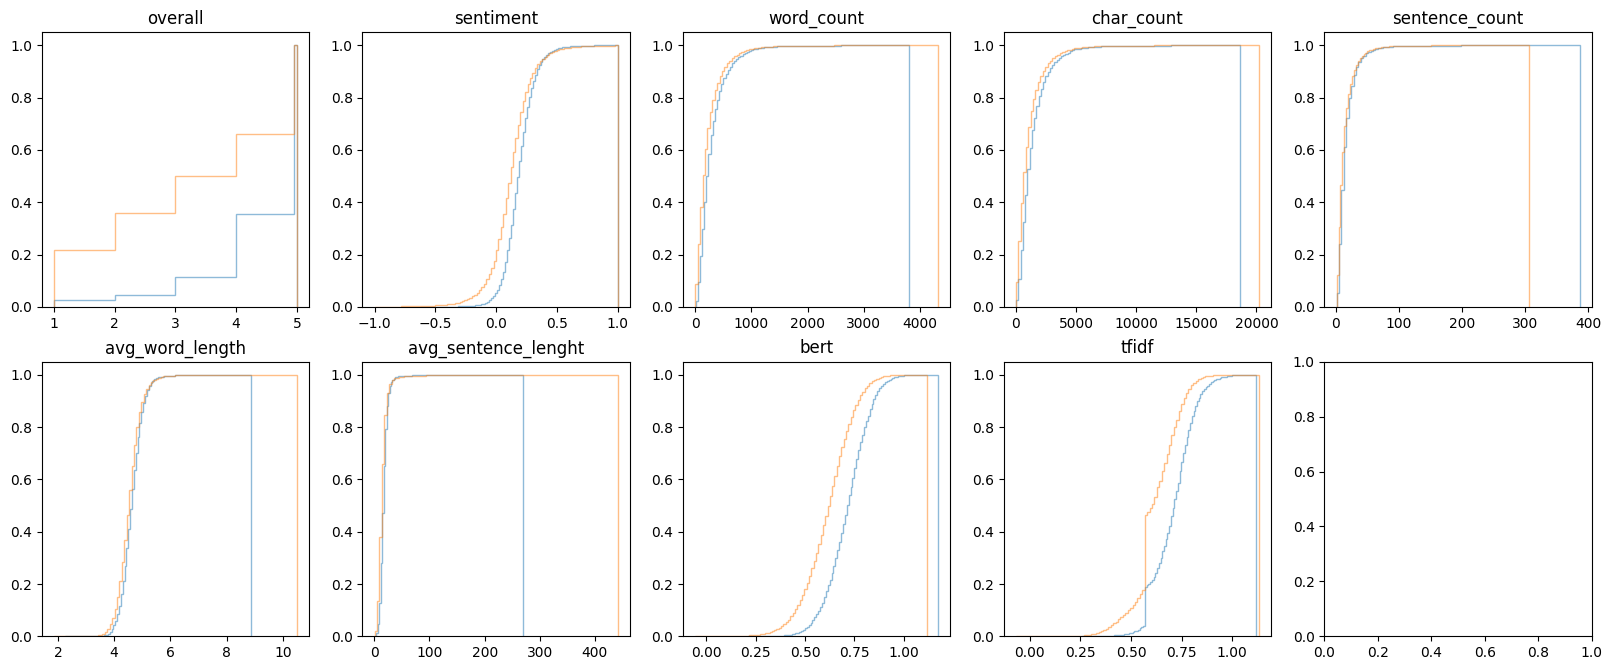

In [44]:
import matplotlib.pyplot as plt
figure, axes = plt.subplots(2, 5, figsize = (20, 8), dpi = 100)
ax = axes.flatten() 
for i, c in enumerate(feature_names):
    ax[i].hist(train_df[c][train_df['label'] == 1], bins = 100, alpha = 0.5, histtype='step', cumulative = True,density=True, label = '1')
    ax[i].hist(train_df[c][train_df['label'] == 0], bins= 100, alpha = 0.5, histtype='step', cumulative = True,density=True, label = '0')
    ax[i].set_title(c, fontsize=15)
    ax[i].set_title(c)
    
#plt.savefig("features.png") #保存作的图
plt.show()

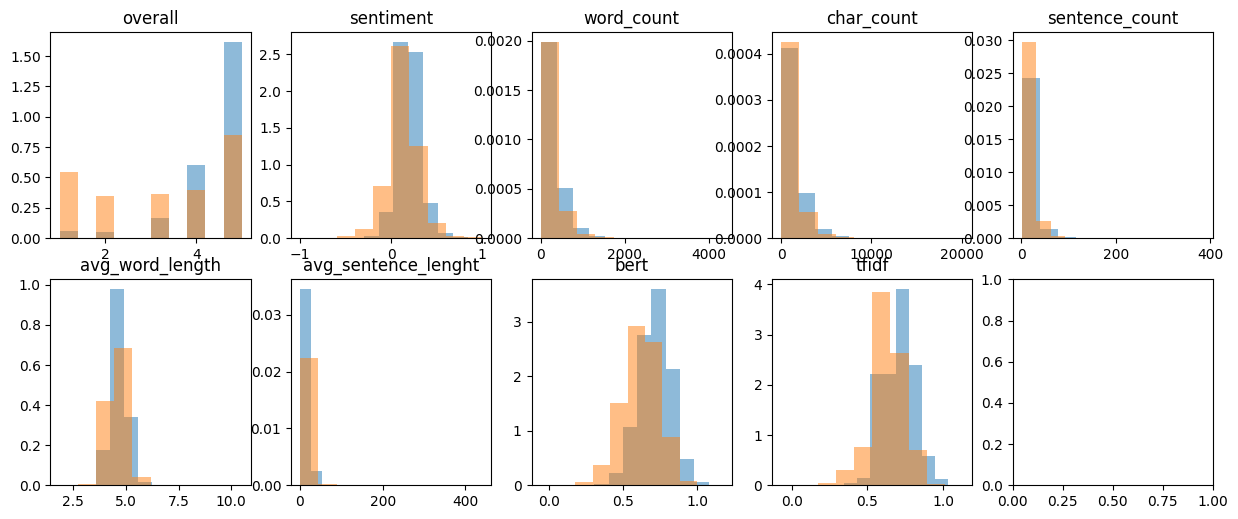

In [46]:
import matplotlib.pyplot as plt
figure, axes = plt.subplots(2, 5, figsize = (15, 6), dpi = 100)
ax = axes.flatten() 
for i, c in enumerate(feature_names):
    ax[i].hist(train_df[c][train_df['label'] == 1], bins = 10, alpha = 0.5, cumulative = False, density=True, label = '1')
    ax[i].hist(train_df[c][train_df['label'] == 0], bins= 10, alpha = 0.5, cumulative = False, density=True, label = '0')
    ax[i].set_title(c, fontsize=15)
    ax[i].set_title(c)
    
#plt.savefig("features.png") #保存作的图
plt.show()

In [47]:
#选取特征
feature_names = ['overall',	'sentiment',	'word_count',	'char_count',	'sentence_count',	'avg_word_length',	'avg_sentence_lenght', 'bert', 'tfidf']

In [48]:
from sklearn.model_selection import train_test_split
#将这些特征取出，生成numpy矩阵
X_train = discrete_train_df[feature_names].values 
all_label_train = discrete_train_df['label'].values
all_score_train = discrete_train_df['score'].values
x_test = discrete_test_df[feature_names].values 
x_train, x_val, label_train, label_val, score_train, score_val = train_test_split(X_train, all_label_train, all_score_train, test_size= 0.2, random_state=2020) 

In [49]:
#仅情绪特征

feature_names = ['sentiment']
X_train = discrete_train_df[feature_names].values 
all_label_train = discrete_train_df['label'].values
all_score_train = discrete_train_df['score'].values
x_test = discrete_test_df[feature_names].values 
x_train, x_val, label_train, label_val, score_train, score_val = train_test_split(X_train, 
            all_label_train, all_score_train, test_size= 0.2, random_state=2020) 
model = Bagging(ml = 'MLPRegressor')
model.fit(x_train, score_train)
pred = model.predict(x_train)
print(pred)
print("train AUC score:", roc_auc_score(label_train, pred))
val_pred = model.predict(x_val)
print("val AUC score:", roc_auc_score(label_val, val_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  0  done in 1.217692s auc: 0.6465790858845704


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  1  done in 1.246078s auc: 0.6460108932033387


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  2  done in 1.179970s auc: 0.6469728515869141


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  3  done in 1.159539s auc: 0.6463869580880133


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  4  done in 1.210946s auc: 0.645987311314372


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  5  done in 1.131527s auc: 0.6468477608712522


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  6  done in 1.137071s auc: 0.6458152611770323


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  7  done in 1.113309s auc: 0.6465416338290851


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  8  done in 1.147448s auc: 0.6465006377698144


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  9  done in 1.116208s auc: 0.6464482704507192
[0.72950871 0.65594795 0.71138556 ... 0.6725106  0.72087607 0.70628697]
train AUC score: 0.6464245760972361
val AUC score: 0.647584447294986


In [50]:
#仅计数特征
feature_names = ['word_count',	'char_count',	'sentence_count',	'avg_word_length',	'avg_sentence_lenght']
X_train = discrete_train_df[feature_names].values 
all_label_train = discrete_train_df['label'].values
all_score_train = discrete_train_df['score'].values
x_test = discrete_test_df[feature_names].values 
x_train, x_val, label_train, label_val, score_train, score_val = train_test_split(X_train, 
            all_label_train, all_score_train, test_size= 0.2, random_state=2020) 
model = Bagging(ml = 'MLPRegressor')
model.fit(x_train, score_train)
pred = model.predict(x_train)
print(pred)
print("train AUC score:", roc_auc_score(label_train, pred))
val_pred = model.predict(x_val)
print("val AUC score:", roc_auc_score(label_val, val_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  0  done in 1.156910s auc: 0.618845004228803


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  1  done in 1.153096s auc: 0.6188589361136536


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  2  done in 1.197423s auc: 0.6201351944180953


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  3  done in 1.169169s auc: 0.6200209222403053


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  4  done in 1.167015s auc: 0.6208322193174375


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  5  done in 1.143175s auc: 0.6186279916007111


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  6  done in 1.164284s auc: 0.620529953099828


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  7  done in 1.150928s auc: 0.6195499318177011


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  8  done in 1.148237s auc: 0.6194263744597143


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  9  done in 1.169888s auc: 0.6212309005420598
[0.69631272 0.67382412 0.48721355 ... 0.74115506 0.68431776 0.6496229 ]
train AUC score: 0.6199902111982125
val AUC score: 0.6282361983737847


In [51]:
#bert + MLP
x_train, x_val, label_train, label_val, score_train, score_val = train_test_split(bert_train, #bert
            all_label_train, all_score_train, test_size= 0.2, random_state=2020) 
model = Bagging(ml = 'MLPRegressor')
model.fit(x_train, score_train)
print("done in %fs" % (time() - t0))

t0 = time()
pred = model.predict(x_train)
print("done in %fs" % (time() - t0))
print(pred)
print("train AUC score:", roc_auc_score(label_train, pred))
val_pred = model.predict(x_val)
print("val AUC score:", roc_auc_score(label_val, val_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  0  done in 8.953406s auc: 0.7104639399946395


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  1  done in 8.728054s auc: 0.701787864875694


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  2  done in 8.374275s auc: 0.7100605846349936


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  3  done in 9.419550s auc: 0.7134310117831817


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  4  done in 8.511443s auc: 0.6973536687831665


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  5  done in 8.498921s auc: 0.7174002603635847


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  6  done in 9.447621s auc: 0.7153492175473283


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  7  done in 8.463157s auc: 0.7094424741666948


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  8  done in 8.363644s auc: 0.7142524388959024


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  9  done in 8.700317s auc: 0.7168434019111781
done in 146.419494s
done in 3.909341s
[0.78131111 0.70176506 0.65792164 ... 0.54456541 0.58133326 0.52657732]
train AUC score: 0.7201629978409829
val AUC score: 0.7076707538299464


In [52]:
#tfidf + MLP
x_train, x_val, label_train, label_val, score_train, score_val = train_test_split(tfidf_best_train, 
            all_label_train, all_score_train, test_size= 0.2, random_state=2020) 
model = Bagging(ml = 'MLPRegressor')
model.fit(x_train, score_train)
print("done in %fs" % (time() - t0))

t0 = time()
pred = model.predict(x_train)
print("done in %fs" % (time() - t0))
print(pred)
print("train AUC score:", roc_auc_score(label_train, pred))
val_pred = model.predict(x_val)
print("val AUC score:", roc_auc_score(label_val, val_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  0  done in 2.017514s auc: 0.6961753876453011


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  1  done in 2.001540s auc: 0.6965729922279064


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  2  done in 2.018388s auc: 0.6959557046707034


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  3  done in 2.019018s auc: 0.6964874835359491


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  4  done in 2.014575s auc: 0.6968633618941087


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  5  done in 2.015063s auc: 0.6966545084295309


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  6  done in 2.024090s auc: 0.6965802941923624


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  7  done in 2.017593s auc: 0.6972010914653888


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  8  done in 2.028199s auc: 0.6965075653097219


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


round  9  done in 2.007411s auc: 0.6963237269709358
done in 25.834571s
done in 0.413582s
[0.67875079 0.61814423 0.67336516 ... 0.69492963 0.62533412 0.58496021]
train AUC score: 0.6968426944819395
val AUC score: 0.7074934667274282


In [53]:
#Bagging boot size对结果的影响 原始 replicate_number = 10, boot_size = 0.6

feature_names = ['overall',	'sentiment',	'word_count',	'char_count',	'sentence_count',	'avg_word_length',	'avg_sentence_lenght', 'bert', 'tfidf']

X_train = discrete_train_df[feature_names].values 
all_label_train = discrete_train_df['label'].values
all_score_train = discrete_train_df['score'].values
x_test = discrete_test_df[feature_names].values 
x_train, x_val, label_train, label_val, score_train, score_val = train_test_split(X_train, 
            all_label_train, all_score_train, test_size= 0.2, random_state=2020) 

boot_sizes = [0.00003, 0.0001, 0.0002, 0.0003, 0.001, 0.003, 0.01, 0.03,  0.1, 0.3, 0.6]
train_auc = []
val_auc = []

for size in boot_sizes:
  model = Bagging(ml = 'DecisionTreeRegressor', boot_size = size)
  model.fit(x_train, score_train)
  pred = model.predict(x_train)
  print(pred)
  print("boot size = ", size)
  tr_auc = roc_auc_score(label_train, pred)
  train_auc.append(tr_auc)
  print("train AUC score:",tr_auc)
  val_pred = model.predict(x_val)
  v_auc = roc_auc_score(label_val, val_pred)
  val_auc.append(v_auc)
  print("val AUC score:", v_auc)

round  0  done in 0.009702s auc: 0.5
round  1  done in 0.009027s auc: 0.5
round  2  done in 0.006410s auc: 0.5
round  3  done in 0.006537s auc: 0.5
round  4  done in 0.006336s auc: 0.5
round  5  done in 0.006236s auc: 0.5
round  6  done in 0.006553s auc: 0.5
round  7  done in 0.006454s auc: 0.5
round  8  done in 0.006676s auc: 0.5
round  9  done in 0.007005s auc: 0.5
[0.7361 0.7361 0.7361 ... 0.7361 0.7361 0.7361]
boot size =  3e-05
train AUC score: 0.5
val AUC score: 0.5
round  0  done in 0.006003s auc: 0.4505347674040416
round  1  done in 0.006211s auc: 0.5946441983409948
round  2  done in 0.006741s auc: 0.4995663423107722
round  3  done in 0.006579s auc: 0.4975484477249704
round  4  done in 0.006438s auc: 0.46130479740984887
round  5  done in 0.006447s auc: 0.46357775603280926
round  6  done in 0.006806s auc: 0.47108846423201833
round  7  done in 0.008235s auc: 0.46354258892713324
round  8  done in 0.007120s auc: 0.5660511291670606
round  9  done in 0.008492s auc: 0.6123339958590565

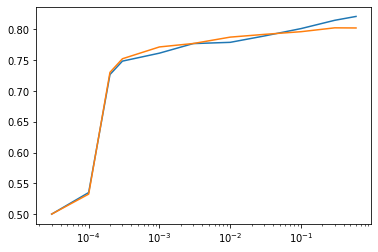

In [54]:
plt.plot(boot_sizes, train_auc)
plt.plot(boot_sizes, val_auc)
plt.xscale('log')

In [58]:
#Bagging replicate_number对结果的影响 原始 replicate_number = 10, boot_size = 0.6

boot_size = 0.0003 #将boot_size设置为train集auc浮动较大,但集成效果不错的值
replicate_numbers = [1, 3, 10, 30, 100, 300, 1000, 3000]
train_auc = []
val_auc = []

for number in replicate_numbers:
  model = Bagging(ml = 'DecisionTreeRegressor', boot_size = boot_size, replicate_number = number)
  model.fit(x_train, score_train)
  pred = model.predict(x_train)
  print(pred)
  print("replicate number = ", number)
  tr_auc = roc_auc_score(label_train, pred)
  train_auc.append(tr_auc)
  print("train AUC score:",tr_auc)
  val_pred = model.predict(x_val)
  v_auc = roc_auc_score(label_val, val_pred)
  val_auc.append(v_auc)
  print("val AUC score:", v_auc)

round  0  done in 0.011224s auc: 0.5885120609827594
[0.86363636 0.76923077 0.33333333 ... 0.90909091 0.94736842 0.86666667]
replicate number =  1
train AUC score: 0.5885120609827594
val AUC score: 0.5918196649746263
round  0  done in 0.006504s auc: 0.5885536193646121
round  1  done in 0.007427s auc: 0.6648674373887407
round  2  done in 0.007477s auc: 0.5573387938422001
[0.87712418 0.6547619  0.24338624 ... 0.65705931 0.5443609  0.84343434]
replicate number =  3
train AUC score: 0.6957916943747691
val AUC score: 0.7011973021944482
round  0  done in 0.006913s auc: 0.5798923662460193
round  1  done in 0.007398s auc: 0.6940420674346567
round  2  done in 0.007636s auc: 0.5419359842097624
round  3  done in 0.009939s auc: 0.4695913023015206
round  4  done in 0.007233s auc: 0.7215808133121121
round  5  done in 0.007081s auc: 0.5889407469174506
round  6  done in 0.007160s auc: 0.6337354460972248
round  7  done in 0.007300s auc: 0.5997727723021731
round  8  done in 0.008523s auc: 0.5801560036452

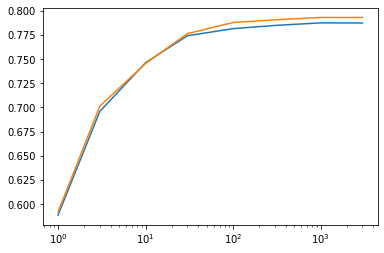

In [59]:
plt.plot(replicate_numbers, train_auc)
plt.plot(replicate_numbers, val_auc)
plt.xscale('log')

In [60]:
#AdaBoost.M1, T对结果的影响 

Ts = [1, 2, 4, 8, 16, 32]
train_auc = []
val_auc = []

for T in Ts:
  model = AdaBoost(ml = 'DecisionTreeRegressor', T = T)
  model.fit(x_train, score_train)
  pred = model.predict(x_train)
  print(pred)
  print("T = ", T)
  tr_auc = roc_auc_score(label_train, pred)
  train_auc.append(tr_auc)
  print("train AUC score:",tr_auc)
  val_pred = model.predict(x_val)
  v_auc = roc_auc_score(label_val, val_pred)
  val_auc.append(v_auc)
  print("val AUC score:", v_auc)

error: 0.16978933620928294
sum of sample_weight: 0.9956417433171747
T =  0  done in 0.524841s auc: 0.8122792928439679
[0.89177056 0.41095426 0.51688611 ... 0.78754345 0.81751665 0.73307843]
T =  1
train AUC score: 0.8122792928439679
val AUC score: 0.7888821141641912
error: 0.16978933620928321
sum of sample_weight: 0.9956417433171747
T =  0  done in 0.530471s auc: 0.8122793147882638
error: 0.16789039657681
sum of sample_weight: 0.996528779346918
T =  1  done in 0.517797s auc: 0.8170136443871443
[0.90009114 0.41095426 0.51494597 ... 0.78677503 0.82697008 0.73119023]
T =  2
train AUC score: 0.8205067524930023
val AUC score: 0.7941737616670606
error: 0.16978933620928283
sum of sample_weight: 0.9956417433171747
T =  0  done in 0.526094s auc: 0.8122792901009308
error: 0.16788368272359974
sum of sample_weight: 0.9964724337061212
T =  1  done in 0.528620s auc: 0.816851613192395
error: 0.16722328342265047
sum of sample_weight: 0.9970081927524923
T =  2  done in 0.515818s auc: 0.8170629888794811

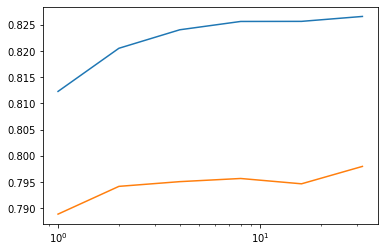

In [61]:
plt.plot(Ts, train_auc)
plt.plot(Ts, val_auc)
plt.xscale('log')

In [68]:
print("val AUC score:", roc_auc_score(label_val, val_pred1))

val AUC score: 0.8025335067569088


In [69]:
test_pred = model.predict(x_test)

In [70]:
test_pred

array([0.24978412, 0.73257559, 0.63560483, ..., 0.58648691, 0.95241429,
       0.34061714])

In [71]:

for i in range(len(test_pred)): #把小于零的改成0，大于1的改成1
  if test_pred[i] < 0: test_pred[i] = 0
  elif test_pred[i] > 1: test_pred[i] = 1

output=pd.DataFrame({'Id':test_df.Id,'Predicted':test_pred})
output.to_csv('/content/drive/MyDrive/Colab Notebooks/xtzx/hw6/results.csv', index=None) 